# MANUAL ARIMA IMPLEMENTATION

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
df = pd.read_csv('/content/stocks.csv',parse_dates=[["YEAR", "MONTH", "DAY"]], index_col="YEAR_MONTH_DAY")
df.index.names = ["DATE"]

In [14]:
# Select the 'CLOSE' column and rename it to 'Value'
df = df[['CLOSE']]
df.columns = ['Value']

Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [15]:
class ARIMA:
    def __init__(self, data, split):
        self.df = data
        self.p = None
        self.d = None
        self.q = None
        self.theta_AR = None
        self.intercept_AR = None
        self.theta_MA = None
        self.intercept_MA = None
        self.df_c = None
        self.df_train = None
        self.split = split
        self.df_diff = np.log(self.df['Value']).diff().dropna()

    def AR(self, p, df):
      df_temp = df.copy()

      #Generating the lagged p terms
      for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

      train_size = (int)(self.split * df_temp.shape[0])

      df_train = df_temp.iloc[:train_size]
      df_test = df_temp.iloc[train_size:]

      df_train_2 = df_train.dropna()
      #X contains the lagged values ,hence we skip the first column
      X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
      #Y contains the value,it is the first column
      y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

      #Running linear regression to generate the coefficents of lagged terms
      lr = LinearRegression()
      lr.fit(X_train,y_train)

      theta  = lr.coef_.T
      intercept = lr.intercept_
      df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
      # df_train_2[['Value','Predicted_Values']].plot()

      X_test = df_test.iloc[:,1:].values.reshape(-1,p)
      df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
      # df_test[['Value','Predicted_Values']].plot()

      RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

      print("The RMSE is :", RMSE,", Value of p : ",p)
      return [df_train_2,df_test,theta,intercept,RMSE]

    def MA(self, q,res):

      for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

      train_size = (int)(self.split * res.shape[0])

      res_train = res.iloc[:train_size]
      res_test = res.iloc[train_size:]

      res_train_2 = res_train.dropna()
      X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
      y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

      lr = LinearRegression()
      lr.fit(X_train,y_train)

      theta  = lr.coef_.T
      intercept = lr.intercept_
      res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
      # res_train_2[['Residuals','Predicted_Values']].plot()

      X_test = res_test.iloc[:,1:].values.reshape(-1,q)
      res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
      #res_test[['Residuals','Predicted_Values']].plot()

      RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

      print("The RMSE is :", RMSE,", Value of q : ",q)
      return [res_train_2,res_test,theta,intercept,RMSE]

    def adf_check(self, time_series):
      """
      Pass in a time series, returns ADF report
      """
      result = adfuller(time_series)
      print('Augmented Dickey-Fuller Test:')
      labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

      for value,label in zip(result,labels):
          print(label+' : '+str(value) )

      if result[1] <= 0.05:
          print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
      else:
          print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

    def fit(self):
      # Prepare data for ARIMA modeling

      # Run the ADF test on the series
      self.adf_check(self.df_diff)
      # Ensure df_testing is a DataFrame with a column named 'Value'
      self.df_diff = pd.DataFrame(self.df_diff, columns=['Value'])

      best_RMSE=100000000000
      best_p = -1

      for i in range(1,21):
        [df_train,df_test,theta,intercept,RMSE] = self.AR(i,pd.DataFrame(self.df_diff.Value))
        if(RMSE<best_RMSE):
          best_RMSE = RMSE
          best_p = i
          self.p = best_p
          self.theta_AR = theta  # Update theta_AR
          self.intercept_AR = intercept  # Update intercept_AR

      print('Best value for p:',best_p)

      [self.df_train,df_test,theta,intercept,RMSE] = self.AR(best_p,pd.DataFrame(self.df_diff.Value))
      self.df_c = pd.concat([self.df_train,df_test])

      res = pd.DataFrame()
      res['Residuals'] = self.df_c.Value - self.df_c.Predicted_Values

      best_RMSE=100000000000
      best_q = -1

      for i in range(1,13):
        [res_train,res_test,theta,intercept,RMSE] = self.MA(i,pd.DataFrame(res.Residuals))
        if(RMSE<best_RMSE):
          best_RMSE = RMSE
          best_q = i
          self.q = best_q
          self.theta_MA = theta  # Update theta_MA
          self.intercept_MA = intercept  # Update intercept_MA

      print('Best value for q:',best_q)

      [res_train,res_test,theta,intercept,RMSE] = self.MA(best_q,pd.DataFrame(res.Residuals))
      # print(theta)
      # print(intercept)

      res_c = pd.concat([res_train,res_test])
      self.df_c.Predicted_Values += res_c.Predicted_Values

      # Revert transformations to obtain the actual 'CLOSE' values
      # Convert the 'Value' column in 'df' to numeric type if it contains dates
      self.df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

      # Extract numeric values from 'Value' column for log transformation
      numeric_values = df['Value'][pd.to_numeric(df['Value'], errors='coerce').notna()]

      # Use index-based access instead of '.Value'
      self.df_c['Value'] += np.log(numeric_values).shift(1)
      self.df_c['Value'] += np.log(numeric_values).diff().shift(12)
      self.df_c['Predicted_Values'] += np.log(numeric_values).shift(1)
      self.df_c['Predicted_Values'] += np.log(numeric_values).diff().shift(12)

      self.df_c['Value'] = np.exp(self.df_c['Value'])
      self.df_c['Predicted_Values'] = np.exp(self.df_c['Predicted_Values'])

    def plot_acf_pacf(self):
      # Ensure df_testing is a DataFrame with a column named 'Value'
      self.df_diff = pd.DataFrame( self.df_diff, columns=['Value'])

      # Calculate the maximum allowable lags
      max_lags = min(50, len( self.df_diff.dropna()) // 2 - 1)

      ACF = plot_acf( self.df_diff.dropna(), lags=min(50, len( self.df_diff.dropna())-1)) # Adjust lags to available data
      PACF = plot_pacf( self.df_diff.dropna(), lags=max_lags)  # Adjust lags to available data

    def test_plot(self):
      RMSE = np.sqrt(mean_squared_error(self.df_c.iloc[self.df_train.shape[0]:]['Value'],self.df_c.iloc[self.df_train.shape[0]:]['Predicted_Values']))
      self.df_c.iloc[self.df_train.shape[0]:][['Value', 'Predicted_Values']].plot()
      print("RMSE:", RMSE)
      mae = mean_absolute_error(self.df_c.iloc[self.df_train.shape[0]:]['Value'],self.df_c.iloc[self.df_train.shape[0]:]['Predicted_Values'])
      print(f'Mean Absolute Error (MAE): {mae:.2f}')

In [19]:
# Initialize ARIMA model
arima_model = ARIMA(df, 0.9)

# Fit the ARIMA model
arima_model.fit()

Augmented Dickey-Fuller Test:
ADF Test Statistic : -30.542764562466317
p-value : 0.0
Number of Lags Used : 0
Number of Observations Used : 1109
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
The RMSE is : 0.016280557825896526 , Value of p :  1
The RMSE is : 0.016315066973679376 , Value of p :  2
The RMSE is : 0.01632445657958466 , Value of p :  3
The RMSE is : 0.016325990692854273 , Value of p :  4
The RMSE is : 0.016329384349413528 , Value of p :  5
The RMSE is : 0.016338797719671453 , Value of p :  6
The RMSE is : 0.01627471947128662 , Value of p :  7
The RMSE is : 0.016264164772537133 , Value of p :  8
The RMSE is : 0.016228426676488255 , Value of p :  9
The RMSE is : 0.016238905490640047 , Value of p :  10
The RMSE is : 0.01624597066965781 , Value of p :  11
The RMSE is : 0.016247232327812368 , Value of p :  12
The RMSE is : 0.0162174663466605 , Value of p :  13
The RMSE is : 0.01616013353296485 , Value of p :  14
Th

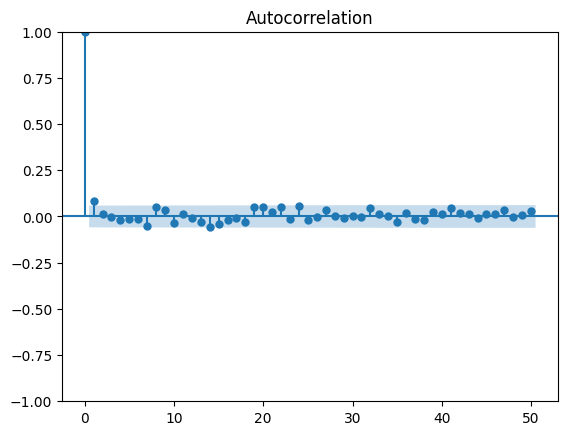

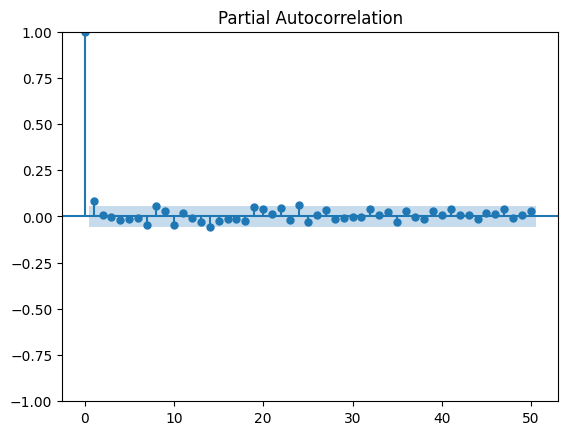

In [12]:
arima_model.plot_acf_pacf()

RMSE: 6.664439994516886
Mean Absolute Error (MAE): 4.61


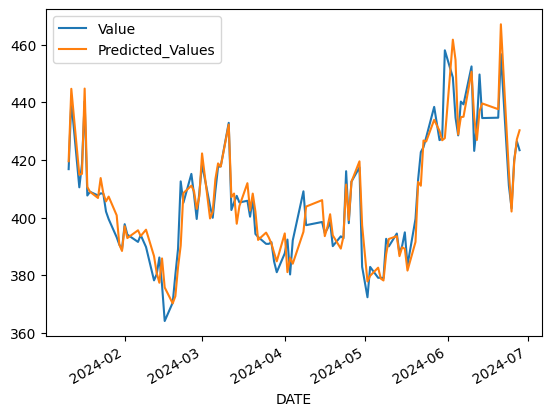

In [20]:
arima_model.test_plot()

#ARIMA USING LIBRARY

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=422.939333, expected=424.240000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=428.061373, expected=424.540000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=425.360025, expected=422.440000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=418.630261, expected=417.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=417.095926, expected=420.100000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=419.170415, expected=416.540000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=414.531586, expected=413.850000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=412.719962, expected=412.680000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=411.351270, expected=412.750000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=414.110940, expected=409.630000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=410.390025, expected=409.850000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=410.052912, expected=405.870000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=408.661417, expected=400.180000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=401.004514, expected=392.950000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=393.541655, expected=392.590000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=393.085602, expected=393.550000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=393.477284, expected=395.390000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=395.702612, expected=397.500000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=396.203110, expected=394.140000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=393.593612, expected=395.100000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=394.001752, expected=389.770000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=388.603313, expected=381.140000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=381.883805, expected=380.180000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=380.689208, expected=389.990000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=392.197880, expected=382.050000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=382.587719, expected=370.870000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=370.365317, expected=370.860000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=372.350936, expected=379.310000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=379.713121, expected=387.370000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=387.386536, expected=410.400000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=410.637362, expected=408.620000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=408.729474, expected=414.180000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=413.515785, expected=413.510000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=410.341704, expected=408.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=409.456630, expected=409.980000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=412.152827, expected=407.990000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=408.303349, expected=412.460000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=415.837008, expected=412.020000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=412.544264, expected=409.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=408.874794, expected=408.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=408.173201, expected=409.120000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=406.833270, expected=408.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=407.171346, expected=404.410000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=402.112050, expected=399.910000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=398.033168, expected=408.230000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=407.216853, expected=410.150000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=409.538962, expected=404.500000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=404.496954, expected=402.310000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=403.898552, expected=402.200000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=403.777156, expected=394.780000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=395.010309, expected=395.940000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=397.032037, expected=391.890000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=393.197843, expected=390.140000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=391.138227, expected=392.010000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=390.876582, expected=388.810000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=387.686291, expected=385.380000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=385.779963, expected=379.730000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=377.706224, expected=390.570000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=390.574975, expected=385.620000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=385.571433, expected=394.280000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=394.346033, expected=409.250000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=411.403547, expected=404.880000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=404.564167, expected=397.340000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=397.319847, expected=398.680000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=399.555361, expected=397.990000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=399.896706, expected=396.630000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=397.318233, expected=393.340000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=392.427909, expected=397.040000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=399.638706, expected=398.690000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=398.825407, expected=404.570000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=401.690260, expected=403.210000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=402.882125, expected=403.470000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=402.907943, expected=402.170000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=400.399272, expected=387.100000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=385.226164, expected=379.480000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=378.536633, expected=381.640000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=383.140832, expected=379.820000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=380.438373, expected=380.470000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=380.915255, expected=382.210000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=383.390799, expected=389.020000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=389.820298, expected=388.440000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=387.817738, expected=388.770000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=387.216965, expected=388.820000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=389.517195, expected=390.010000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=390.919490, expected=396.190000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=395.392940, expected=398.410000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=399.902765, expected=407.590000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=409.565879, expected=411.060000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=411.783931, expected=424.770000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=425.969298, expected=423.750000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=422.802852, expected=425.880000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=426.467016, expected=430.750000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=430.341376, expected=427.540000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=426.057126, expected=427.120000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=427.302949, expected=457.980000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=458.438807, expected=447.270000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=446.866623, expected=427.920000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=425.092486, expected=426.160000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=424.484446, expected=430.340000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=431.418031, expected=435.590000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=434.608232, expected=437.850000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=436.097497, expected=424.180000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=424.764565, expected=430.210000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=431.445555, expected=444.570000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=441.196256, expected=437.810000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=437.029876, expected=435.100000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=437.559839, expected=425.980000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=424.471157, expected=420.940000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=421.800936, expected=421.510000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=421.909408, expected=421.870000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=422.418788, expected=422.320000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=426.963660, expected=418.300000
Test RMSE: 6.691
Mean Absolute Error (MAE): 4.59


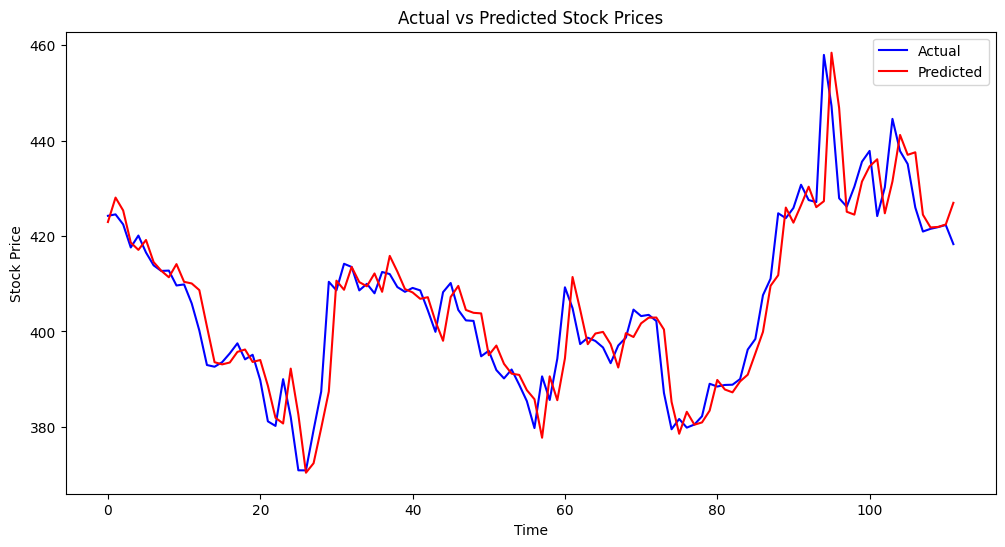

In [2]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
# load dataset

series = read_csv('/content/stocks.csv', header=0, index_col=0, parse_dates=True)
series.index = series.index.to_period('M')
# Select a single column for univariate analysis
# Assuming 'CLOSE' is the column you want to predict
series = series['CLOSE']
# split into train and test sets
X = series.values
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(19,1,6))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
# Plot forecasts against actual outcomes
pyplot.figure(figsize=(12, 6))
pyplot.plot(test, label='Actual', color='blue')
pyplot.plot(predictions, label='Predicted', color='red')
pyplot.title('Actual vs Predicted Stock Prices')
pyplot.xlabel('Time')
pyplot.ylabel('Stock Price')
pyplot.legend()
pyplot.show()